In [1]:
import pybammeis
import pybamm
import numpy as np
import time as timer
import matplotlib.pyplot as plt
from scipy.fft import fft



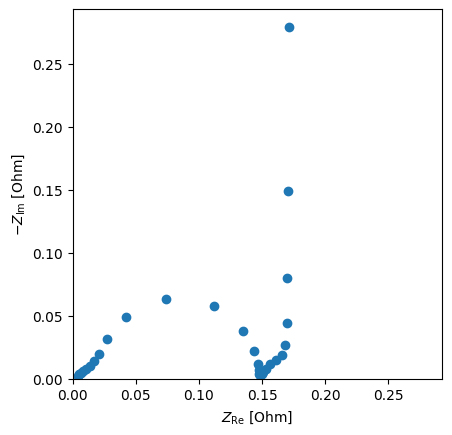

<Axes: xlabel='$Z_\\mathrm{Re}$ [Ohm]', ylabel='$-Z_\\mathrm{Im}$ [Ohm]'>

In [2]:

# DFN with capacitance
model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
eis_sim = pybammeis.EISSimulation(model)
# calculate impedance at log-spaced frequencies
eis_sim.solve(np.logspace(-4, 4, 30))

eis_sim.nyquist_plot()

Pybamm-eis functions 

Numerical methods (iterative numerical method):
- autofunction: pybammeis.bicgstab 
- autofunction: pybammeis.prebicgstab 

Plotting: 
- autofunction: pybammeeis.nyquist_plot

Simulation: 
- autoclass: pybammeis.EISSimulation

Utilities: 
- autoclass: pybammeis.SymbolReplacer

Compare methods

Time domain method:  38.654202938079834 s
Frequency domain (direct):  0.4162430763244629 s
Frequency domain (bicgstab):  0.3559842109680176 s
Frequency domain (prebicgstab):  0.31652188301086426 s


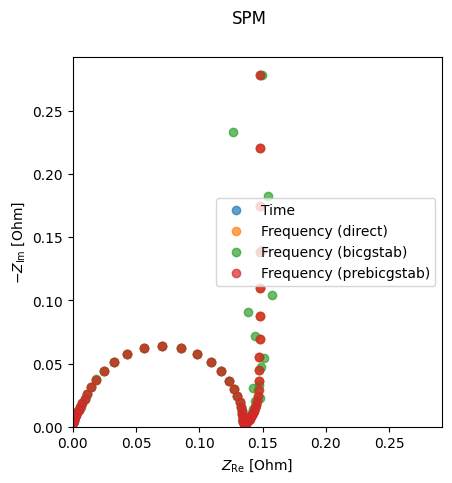

In [3]:

# Set up
model = pybamm.lithium_ion.SPM(options={"surface form": "differential"}, name="SPM")
parameter_values = pybamm.ParameterValues("Marquis2019")
frequencies = np.logspace(-4, 3, 70)
# Ser ut som man kan putte inn parametre

# Time domain
I_app = 5e-3
number_of_periods = 10
samples_per_period = 56
# Ser ut som man kan putte inn number of periods og samples per period også
# Ann_Mari snakket om at jeg bare trengte én periode og 50 samples per periode. 


def current_function(t):
    return I_app * pybamm.sin(2 * np.pi * pybamm.InputParameter("Frequency [Hz]") * t)


parameter_values["Current function [A]"] = current_function
# Oppdaterer parametrene til å ha en current function!! 

start_time = timer.time()

sim = pybamm.Simulation(
    model, parameter_values=parameter_values, solver=pybamm.ScipySolver(atol=1e-12)
)
# Så simuleringen avhenger av modellen, parametermodellen, osv. 

impedances_time = []
for frequency in frequencies:
    # Solve
    period = 1 / frequency
    dt = period / samples_per_period
    t_eval = np.array(range(0, samples_per_period * number_of_periods)) * dt
    sol = sim.solve(t_eval, inputs={"Frequency [Hz]": frequency})
    # Extract final two periods of the solution
    time = sol["Time [s]"].entries[-5 * samples_per_period :]
    current = sol["Current [A]"].entries[-5 * samples_per_period :]
    voltage = sol["Voltage [V]"].entries[-5 * samples_per_period :]
    # Vet ikke hvorfor man starter listene så langt bak? 
    # FFT - Fourier transform av current og voltage! 
    current_fft = fft(current)
    voltage_fft = fft(voltage)
    # Get index of first harmonic - the fundamental frequency itself (representing the primary sine wave)
    # Higher harmonics are multiples of this base frequency and contribute to the overall wave shape. 
    # Since they only find the first harmonic - are they assuming that the response is pseudo-linear? 
    idx = np.argmax(np.abs(current_fft))
    impedance = -voltage_fft[idx] / current_fft[idx]
    impedances_time.append(impedance)

end_time = timer.time()
time_elapsed = end_time - start_time
print("Time domain method: ", time_elapsed, "s")

# Frequency domain
methods = ["direct", "bicgstab", "prebicgstab"]
impedances_freqs = []
for method in methods:
    start_time = timer.time()
    eis_sim = pybammeis.EISSimulation(model, parameter_values=parameter_values)
    impedances_freq = eis_sim.solve(frequencies, method)
    # Du kan velge hvilken metode man kan bruke for å løse EIS. 
    end_time = timer.time()
    time_elapsed = end_time - start_time
    print(f"Frequency domain ({method}): ", time_elapsed, "s")
    impedances_freqs.append(impedances_freq)

# Compare
_, ax = plt.subplots()
ax = pybammeis.nyquist_plot(impedances_time, ax=ax, label="Time", alpha=0.7)
for i, method in enumerate(methods):
    ax = pybammeis.nyquist_plot(
        impedances_freqs[i], ax=ax, label=f"Frequency ({method})", alpha=0.7
    )

ax.legend()
plt.suptitle(f"{model.name}")
plt.show()

Time and Frequency Domains and Transforms 

Under the subtitle "Time and Frequency Domains and Transforms" in the article "Basics of EIS" there is information about the two different domains: 
- Usually, the lower frequency data are measured in the time domain: 
- digital-to-analog converter applies a sinus curve --> current response is measured by a analog-to-digital converter --> FFT is used to convert the current signal into the frequency domain. 

- In this code, you can compute directly in the frequency domain, using 3 different methods: direct, bicgstab or prebicgstab numerical methods (the difference is direct or iterative methods). 


Compare models

Start calculating impedance for SPM
Finished calculating impedance for SPM
Number of states:  46 Set-up time:  263.082 ms Solve time:  38.035 ms
Start calculating impedance for SPMe
Finished calculating impedance for SPMe
Number of states:  106 Set-up time:  570.690 ms Solve time:  205.800 ms
Start calculating impedance for DFN
Finished calculating impedance for DFN
Number of states:  904 Set-up time:  593.059 ms Solve time:  244.789 ms
Start calculating impedance for SPM (pouch)
Finished calculating impedance for SPM (pouch)
Number of states:  4404 Set-up time:  686.982 ms Solve time:  480.183 ms
Start calculating impedance for DFN (pouch)
Finished calculating impedance for DFN (pouch)
Number of states:  45204 Set-up time:  3.436 s Solve time:  8.653 s


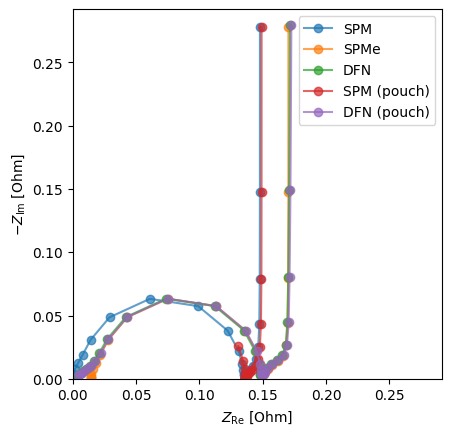

In [4]:
# Load models and parameters
models = [
    pybamm.lithium_ion.SPM(
        options={
            "surface form": "differential",
        },
        name="SPM",
    ),
    pybamm.lithium_ion.SPMe(options={"surface form": "differential"}, name="SPMe"),
    pybamm.lithium_ion.DFN(options={"surface form": "differential"}, name="DFN"),
    pybamm.lithium_ion.SPM(
        {
            "surface form": "differential",
            "current collector": "potential pair",
            "dimensionality": 2,
        },
        name="SPM (pouch)",
    ),
    pybamm.lithium_ion.DFN(
        {
            "surface form": "differential",
            "current collector": "potential pair",
            "dimensionality": 2,
        },
        name="DFN (pouch)",
    ),
]
parameter_values = pybamm.ParameterValues("Marquis2019")
parameter_values = pybamm.get_size_distribution_parameters(
    parameter_values, sd_n=0.2, sd_p=0.4
)

# Loop over models and calculate impedance
frequencies = np.logspace(-4, 4, 30)
impedances = []
for model in models:
    print(f"Start calculating impedance for {model.name}")
    eis_sim = pybammeis.EISSimulation(model, parameter_values=parameter_values)
    impedances_freq = eis_sim.solve(
        frequencies,
    )
    print(f"Finished calculating impedance for {model.name}")
    print(
        "Number of states: ",
        eis_sim.y0.shape[0],
        "Set-up time: ",
        eis_sim.set_up_time,
        "Solve time: ",
        eis_sim.solve_time,
    )
    impedances.append(impedances_freq)

# Compare
_, ax = plt.subplots()
for i, model in enumerate(models):
    ax = pybammeis.nyquist_plot(
        impedances[i], ax=ax, linestyle="-", label=f"{model.name}", alpha=0.7
    )
ax.legend()
plt.show()

Parameters

Man kan bruke parameter_values.update({})! Se pybamm-eis/examples/parameter_sweep for instruksjon

- parameter_values.update for å oppdatere parameteren 
- her kan man også ha en "parameter input" funksjon i solver --> for å sette inn den oppdaterte parameteren 
- SOC kan også være en parameter input i solver! Her har modellen en funksjon som heter "get_min_max_stoiciometries" som avhenger av parametrene dine.  

Kommentar: tror denne input-funksjonen er veldig relevant for oppgaven - her kan jeg lage funksjonen på forhånd og bare pjåte de optimiserte parametrene rett inn, evt tilpasse parameterne til å få best mulig EIS! 

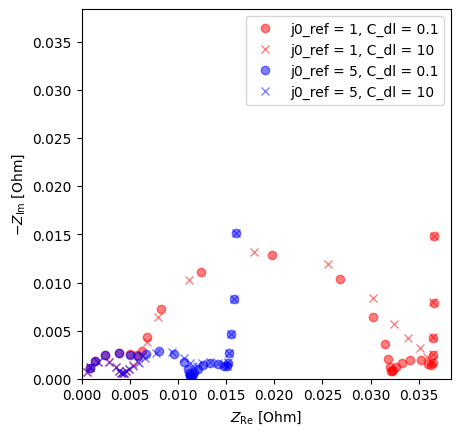

In [5]:

# Load model
model = pybamm.lithium_ion.DFN(
    options={"working electrode": "positive", "surface form": "differential"}
)

# Load parameters
parameter_values = pybamm.ParameterValues("OKane2022_graphite_SiOx_halfcell")


def j0(c_e, c_s_surf, c_s_max, T):
    j0_ref = pybamm.Parameter(
        "Positive electrode reference exchange-current density [A.m-2]"
    )
    c_e_init = pybamm.Parameter("Initial concentration in electrolyte [mol.m-3]")

    return (
        j0_ref
        * (c_e / c_e_init) ** 0.5
        * (c_s_surf / c_s_max) ** 0.5
        * (1 - c_s_surf / c_s_max) ** 0.5
    )


parameter_values.update(
    {
        "Positive electrode reference exchange-current density [A.m-2]": pybamm.InputParameter(
            "j0_ref"
        ),
        "Positive electrode exchange-current density [A.m-2]": j0,
        "Positive electrode double-layer capacity [F.m-2]": pybamm.InputParameter(
            "C_dl"
        ),
    },
    check_already_exists=False,
)

# Create simulation
eis_sim = pybammeis.EISSimulation(model, parameter_values=parameter_values)

# Choose frequencies and calculate impedance, looping over input parameter values
# and adding the results to a Nyquist plot
frequencies = np.logspace(-4, 4, 30)

j0_refs = [1, 5]
C_dls = [0.1, 10]
markers = ["o", "x"]
colors = ["r", "b"]

_, ax = plt.subplots()
for i, j0_ref in enumerate(j0_refs):
    for j, C_dl in enumerate(C_dls):
        eis_sim.solve(frequencies, inputs={"j0_ref": j0_ref, "C_dl": C_dl})
        eis_sim.nyquist_plot(
            ax=ax,
            marker=markers[j],
            color=colors[i],
            alpha=0.5,
            label=f"j0_ref = {j0_ref}, C_dl = {C_dl}",
        )
ax.legend()
plt.show()

# Kommentar: vet ikke hvor c_e, c_s_surf eller c_s_max kommer fra i j_0 funksjonen
# Men tror at disse avhenger av input-parameteren C_dl? 

Her er:
- j0_ref = "Positive electrode reference exchange-current density [A.m-2]
- C_dls = "Positive electrode double-layer capacity [F.m-2]

State of Charge (SOC)

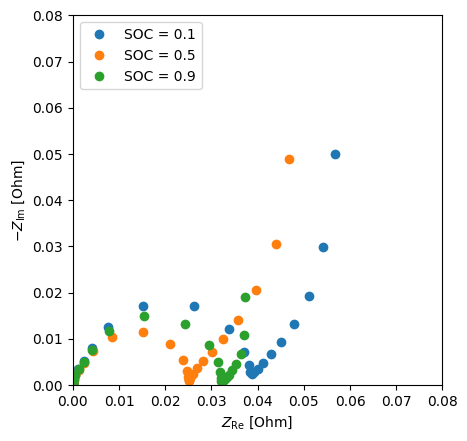

In [6]:
# Load model
model = pybamm.lithium_ion.SPM(options={"surface form": "differential"})

# Set up parameters with cell SOC as an input parameter
parameter_values = pybamm.ParameterValues("Chen2020")

x0, x100, y100, y0 = pybamm.lithium_ion.get_min_max_stoichiometries(parameter_values)
z = pybamm.InputParameter("SOC")
x = x0 + z * (x100 - x0)
y = y0 - z * (y0 - y100)
c_n_max = parameter_values["Maximum concentration in negative electrode [mol.m-3]"]
c_p_max = parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": x * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": y * c_p_max,
    }
)

# Create simulation
eis_sim = pybammeis.EISSimulation(model, parameter_values=parameter_values)

# Choose frequencies and calculate impedance, looping over input parameter values
# and adding the results to a Nyquist plot
frequencies = np.logspace(-4, 4, 30)
_, ax = plt.subplots()
for z in [0.1, 0.5, 0.9]:
    eis_sim.solve(frequencies, inputs={"SOC": z})
    eis_sim.nyquist_plot(ax=ax, label=f"SOC = {z}")
ax.set_xlim([0, 0.08])
ax.set_ylim([0, 0.08])
ax.legend()
plt.show()

Bygge sin egen modell

Man kan også bygge og kjøre EIS simuleringer (med en frequency domain approach) fra bunnen av ved å bruke pybamm og definere en rekke funksjoner. Vet ikke hvor viktig/relevant dette er for oppgaven ettersom den eksisterende pybammeis virker tilstrekkelig nok for vårt formål. I så fall, hvis jeg skal bygge modellen fra bunnen av, trenger jeg nok hjelp til å forstå meg på koden:) Ligger under pybamm-eis/pybammeis/eis_simulation.py. Jeg har likevel notert meg et par "calls" de bruker for å definere ulike funksjoner: 

- pybamm.BaseModel
- pybamm.Geometry
- pybamm.FiniteVolume
- pybamm.Timer()
- pybamm.logger.info
- sim.build()
- pybamm.Variable 
- pybammeis.SymbolReplacer
- pybamm.FunctionParameter
- pybamm.BaseSolver()

Jeg kan jo prøve å definere en "Bode plot" funskjon da. 

Bicgstab - iterativ metode i numerisk linear algebra (antar at vi har så små frekvenser at current vs voltage er pseudo-lineær.)

Prebicgstab - bruker "preconditioned" bicgstab method - betinger et problem til en form som er mer egnet for numeriske løsningsmetoder. 

Nyquist plot - står hvordan denne funksjonen er laget i pybamm-eis/pybammeis/plotting.py - kanskje lage en tilsvarende funksjon for Bode plot? 

Test simulation - her kan man teste simuleringsmetoden sin! Har ikke prøvd ennå. 
- (Kan også teste utilities - se pybamm-eis/tests/test_utils.py)

In [7]:
def test_compare_methods():
    # Set up
    model = pybamm.lithium_ion.SPM(options={"surface form": "differential"}, name="SPM")
    parameter_values = pybamm.ParameterValues("Marquis2019")
    frequencies = np.logspace(-4, 2, 30)

    # Time domain
    I_app = 50 * 1e-3
    number_of_periods = 20
    samples_per_period = 16

    def current_function(t):
        return I_app * pybamm.sin(
            2 * np.pi * pybamm.InputParameter("Frequency [Hz]") * t
        )

    parameter_values["Current function [A]"] = current_function

    sim = pybamm.Simulation(
        model, parameter_values=parameter_values, solver=pybamm.ScipySolver()
    )

    impedances_time = []
    for frequency in frequencies:
        # Solve
        period = 1 / frequency
        dt = period / samples_per_period
        t_eval = np.array(range(0, 1 + samples_per_period * number_of_periods)) * dt
        sol = sim.solve(t_eval, inputs={"Frequency [Hz]": frequency})
        # Extract final two periods of the solution
        current = sol["Current [A]"].entries[-3 * samples_per_period - 1 :]
        voltage = sol["Voltage [V]"].entries[-3 * samples_per_period - 1 :]
        # FFT
        current_fft = fft(current)
        voltage_fft = fft(voltage)
        # Get index of first harmonic
        idx = np.argmax(np.abs(current_fft))
        impedance = -voltage_fft[idx] / current_fft[idx]
        impedances_time.append(impedance)
    impedances_time = np.array(impedances_time)

    # Frequency domain
    methods = ["direct"]
    impedances_freqs = {}
    for method in methods:
        eis_sim = pybammeis.EISSimulation(model, parameter_values=parameter_values)
        impedances_freq = eis_sim.solve(frequencies, method)
        impedances_freqs[method] = impedances_freq

    for method in methods:
        assert np.allclose(
            impedances_time.real, impedances_freqs[method].real, rtol=1e-1
        )
        assert np.allclose(
            impedances_time.imag, impedances_freqs[method].imag, rtol=1e-1
        )


def test_solve_with_inputs():
    model = pybamm.lithium_ion.DFN(
        options={"working electrode": "positive", "surface form": "differential"}
    )
    parameter_values = pybamm.ParameterValues("OKane2022_graphite_SiOx_halfcell")
    parameter_values.update(
        {
            "Positive electrode double-layer capacity [F.m-2]": pybamm.InputParameter(
                "C_dl"
            ),
        },
    )
    eis_sim = pybammeis.EISSimulation(model, parameter_values=parameter_values)
    frequencies = np.logspace(-4, 4, 30)
    eis_sim.solve(frequencies, inputs={"C_dl": 0.1})


def test_bad_method():
    model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
    eis_sim = pybammeis.EISSimulation(model)
    frequencies = np.logspace(-4, 4, 30)
    with pytest.raises(ValueError, match="'method' must be"):
        eis_sim.solve(frequencies, method="bad_method")

Defined functions in pybamm that affect the EIS simulations: 
- Exchange current density: graphite_LGM50_electrolyte_exchange_current_density_Chen2020 and nmc_LGM50_electrolyte_exchange_current_density_Chen2020
- how does this relate to the charge transfer resistance? butler volmer as it takes in exchange current density and gives you the overpotential? 

- Butler-Volmer equation: 

- Ohmic resistance: constant (ionic conductivity of the electrolyte and the electronic conductivity of the electrodes.)

- Mass transport (diffusion) resistance: (ionic diffusion in the electrolyte and solid-state diffusion within the electrode materials). 

Exchange current density 

In [ ]:
def nmc_LGM50_electrolyte_exchange_current_density_Chen2020(c_e, c_s_surf, c_s_max, T):
    m_ref = 3.42e-6  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 17800
    arrhenius = np.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5


def graphite_LGM50_electrolyte_exchange_current_density_Chen2020(
    c_e, c_s_surf, c_s_max, T
):
    m_ref = 6.48e-7  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 35000
    arrhenius = np.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5


Butler-Volmer - do not know if there is use in looking at this, since both the symmetric and asymmetric BV takes in "BaseKinetics" whatever this means. 

Electrolyte conductivity 

In [ ]:
def electrolyte_conductivity_Nyman2008(c_e, T):
    
    sigma_e = (
        0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000)
    )

    # Nyman et al. (2008) does not provide temperature dependence

    return sigma_e


Electrolyte diffusivity 

In [ ]:
def electrolyte_diffusivity_Nyman2008(c_e, T):
    D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10

    # Nyman et al. (2008) does not provide temperature dependence

    return D_c_e

In [12]:


e_height = 0.059    #params['Electrode height [m]']
e_width = 0.9033043292355315      #params['Electrode width [m]']
e_A = e_height*e_width

s_thick = 1.0598531461526225e-05 #params['Separator thickness [m]']
anode_thick = 0.00019850124472796743 #params['Negative electrode thickness [m]']
cathode_thick = 6.62e-05 #params['Positive electrode thickness [m]']

# For small overpotentials and assuming a symmetrical charge transfer process, 
#i_0 = (R*T)/(n*F*Rct) 
#From Butler-Volmer! 
i_0  = 0.0257 * 0.004924506328399464 #from Randles circuit 

# Diffusivity from the Warburg coefficient A: 
# D = ((R*T)/(n*F*area*A))**2
#D = ((8.314*298)/(1*96485*area*.002162371149615444))**2


# parameters I want to change to optimize the graph: 
p = {
    #Capacity - analog to Cdl/CPE in the Randles circuit 
    'Negative electrode double-layer capacity [F.m-2]': 0.320907453/e_A, #constant or function? 
    'Positive electrode double-layer capacity [F.m-2]': 0.320907453/e_A, #constant or function? 

    #Exchange current density - analog to Rct in the Randles circuit through the Butler-Volmer 
    #"Positive electrode reference exchange-current density [A.m-2]": , #do not think this is needed
    "Positive electrode exchange-current density [A.m-2]": 0.004924506328399464, #function
    "Negative electrode exchange-current density [A.m-2]": 0.004924506328399464, #function 

    #Omic resistance - analog to Rel in the Randles circuit? 
    "Electrolyte conductivity [S.m-1]": 1/(s_thick*0.013217154712578262), #function  
    "Negative electrode conductivity [S.m-1]": 1/(anode_thick*0.013217154712578262), #function
    "Positive electrode conductivity [S.m-1]": 1/(cathode_thick*0.013217154712578262), #function

    #Mass transfer resistance - analog to W in the Randles circuit? 
    "Electrolyte diffusivity [m2.s-1]": ((8.314*298)/(1*96485*e_height*s_thick*.002162371149615444))**2, #function
    "Negative particle diffusivity [m2.s-1]": ((8.314*298)/(1*96485*e_height*anode_thick*.002162371149615444))**2,
    "Positive particle diffusivity [m2.s-1]": ((8.314*298)/(1*96485*e_height*cathode_thick*.002162371149615444))**2  
     }

print(p)

{'Negative electrode double-layer capacity [F.m-2]': 6.02134761989294, 'Positive electrode double-layer capacity [F.m-2]': 6.02134761989294, 'Positive electrode exchange-current density [A.m-2]': 0.004924506328399464, 'Negative electrode exchange-current density [A.m-2]': 0.004924506328399464, 'Electrolyte conductivity [S.m-1]': 7138654.002652527, 'Negative electrode conductivity [S.m-1]': 381152.51692123554, 'Positive electrode conductivity [S.m-1]': 1142888.9583091077, 'Electrolyte diffusivity [m2.s-1]': 360642644891216.9, 'Negative particle diffusivity [m2.s-1]': 1028115714520.4261, 'Positive particle diffusivity [m2.s-1]': 9243841436422.555}


In [ ]:


# Function to convert dictionary to list
def dict_to_list(c_elem):
    return list(c_elem.values())

# Function to convert list back to dictionary
def list_to_dict(c_elem, optimized_values):
    keys = list(c_elem.keys())
    return dict(zip(keys, optimized_values))

init_params = dict_to_list(p)


def Z_sim(frequencies, upt_par):
  model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
  params.update(
    {'Negative electrode double-layer capacity [F.m-2]': upt_par[0], 
     'Positive electrode double-layer capacity [F.m-2]': upt_par[1], 

     "Positive electrode exchange-current density [A.m-2]": upt_par[2], 
     "Negative electrode exchange-current density [A.m-2]": upt_par[3], 

     "Electrolyte conductivity [S.m-1]": upt_par[4], 
     "Negative electrode conductivity [S.m-1]": upt_par[5], 
     "Positive electrode conductivity [S.m-1]": upt_par[6], 

     "Electrolyte diffusivity [m2.s-1]": upt_par[7]
     "Negative particle diffusivity [m2.s-1]": upt_par[8], 
     "Positive particle diffusivity [m2.s-1]": upt_par[9]
     })
  eis_sim = pybammeis.EISSimulation(model, parameter_values=params)
  z_sim = eis_sim.solve(frequencies, method = "prebicgstab")
  return z_sim 


real_exp = np.array(df_real)
imag_exp = np.array(df_imag)

def diff_function(upt_par, frequencies, real_exp, imag_exp): 
  imp_sim = Z_sim(frequencies, upt_par)
  real_sim = np.real(imp_sim)
  imag_sim = np.imag(imp_sim)

  real_diff = real_sim - real_exp 
  imag_diff = imag_sim - imag_exp 

  #the total sum of squared differences (magnitude, absolute value, of the complex differences)
  sum_square_diff = np.sum(real_diff**2 + imag_diff**2)
  return sum_square_diff

#diff_function(initial_params, frequencies, real_exp, imag_exp)

# to pass the additional arguments
# args = (frequencies, real_exp, imag_exp)
def wrapped_diff_function(upt_par):
  return np.array([diff_function(par, frequencies, real_exp, imag_exp) for par in upt_par])

#lower_bounds = [50e-6,5e-6,0.01,0.01, 40e-3, 0] #, -100
#upper_bounds = [300e-6,50e-6,0.2,0.2, 2, 10] #, 100
#bounds = (lower_bounds, upper_bounds)

n_dim = 10 # changing 6 parameters

options = {'c1': 0.5,      # Cognitive parameter (influence of personal best)
    'c2': 0.3,      # Social parameter (influence of global best)
    'w': 0.9,       # Inertia parameter (how much particles retain velocity)
    }

optimizer = ps.single.GlobalBestPSO(n_particles=2, dimensions=n_dim, options=options)  #, bounds=bounds)

best_cost, best_params = optimizer.optimize(wrapped_diff_function, iters=2)

dic_best_params = list_to_dict(p, best_params)
print("Optimized Parameters:", best_params)
print("Best Cost:", best_cost)

